In [1]:
"""
#### Code adapted from the source code of ArtEmis dataset paper
"""

import json
import torch
import pandas as pd
import os.path as osp
import numpy as np
import itertools
from PIL import Image
from model.func_eval import unpickle_data,torch_load_model
from artemis.utils.vocabulary import Vocabulary #Use for text2emotion metrics
from artemis.evaluation.single_caption_per_image import apply_basic_evaluations
from artemis.emotions import IDX_TO_EMOTION
%load_ext autoreload
%autoreload 2

In [2]:
DBdir = "../Dataset/ArtEmis/ArtEmis_IdC"
modelname = 'CLIPViTB16_woSG' #'CLIPViTB16_full','CLIPViTB16_woSG','INRN34_full','INRN34_woSG','INViTB16_full','INViTB16_woSG'

model_dir = f'output/{modelname}'
sampled_captions_file = osp.join(model_dir,'fullDB_test.pkl')

In [3]:
references_file = osp.join(DBdir,'Artemis_IdCI_GT.pkl')
split = 'test'
gpu_id = 0

# the evaluation of the longest-common-subsequence is quite slow -- so we sub-sampled the data:
default_lcs_sample = [25000, 800]
# First integer (25000) = number of training (gt) sentences to subsample from all training
# Secong integer (800)  = number of sample sentences to subsample from all generations

In [4]:
gt_data = next(unpickle_data(references_file))
train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
print('Unique Training Utterances', len(unique_train_utters))

# now focus on the data (split) that you created captions for
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

device = "cpu"

Training Utterances 75509
Unique Training Utterances 75448
Images Captioned 2497


In [5]:
evaluation_methods = {'bleu', 'meteor', 'rouge'}
print(evaluation_methods) 

{'rouge', 'meteor', 'bleu'}


In [6]:
saved_samples = next(unpickle_data(sampled_captions_file))

for sampling_config_details, captions in saved_samples:  # you might have sampled under several sampling configurations
    merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
    hypothesis = merged.captions_predicted
    references = merged.references_pre_vocab # i.e., use references that do not have <UNK>

    metrics_eval = apply_basic_evaluations(hypothesis, references, None, None, None, 
                                           nltk_bleu=False, lcs_sample=default_lcs_sample,
                                           train_utterances=unique_train_utters,
                                           methods_to_do=evaluation_methods)

    print(pd.DataFrame(metrics_eval))
    print()

BLEU: done
COCO-based-metrics: done
   metric      mean       std
0  BLEU-0  0.597020  0.169700
1  BLEU-1  0.400984  0.187848
2  BLEU-2  0.262234  0.211238
3  BLEU-3  0.177259  0.177623
4  METEOR  0.184553  0.061616
5   ROUGE  0.361235  0.114295



In [7]:
# Load weights of promCLIP
from clip import clip
from model.promCLIP import promCLIP as promCLIP_model
from model.func_train import load_state_dicts
CLIP_name = 'RN50x16'
no_promt_tokens=3
FTpromCLIP_dir = "output/promCLIP/NP3_RN50x16/checkpoints"

orig_CLIP,CLIPtransform,CLIPsettings = clip.load(CLIP_name,device)
embed_dim,image_resolution, vision_layers, vision_width, vision_patch_size,context_length_CLIP, vocab_size_CLIP, transformer_width, transformer_heads, transformer_layers = CLIPsettings
promCLIP = promCLIP_model(embed_dim,image_resolution,vision_layers,vision_width,
            vision_patch_size,no_promt_tokens,context_length_CLIP,
            vocab_size_CLIP,transformer_width,transformer_heads,transformer_layers)

loaded_epoch = load_state_dicts(osp.join(FTpromCLIP_dir,  'best_model.pt'), map_location='cpu', model=promCLIP)
print("load model at epoch=",loaded_epoch)

load model at epoch= 55


In [8]:
# Calculate promCLIP indexes of generated captions
from PIL import Image
from torchvision.transforms import Compose, ToTensor
similarities = []
img_dir = f'../Dataset/ArtEmis/ArtEmis_IdC/Images/CLIP_{image_resolution}/'
img_transform = Compose([ToTensor()])
for i,row in merged.iterrows():
    img_file = osp.join(img_dir, row.art_style,  row.painting + '.jpg')
    image_inputs = torch.unsqueeze(img_transform(Image.open(img_file)), 0)
    capt = row['captions_predicted']
    prompt = f'{capt}'
    text_inputs = clip.tokenize(prompt)
    with torch.no_grad():
        _,score = promCLIP(image_inputs.to(device),text_inputs.to(torch.long).to(device))
    similarities.append(score.squeeze(0).tolist())
promCLIP_score = np.mean((np.array(similarities)))
promCLIP_score

26.463497801212775

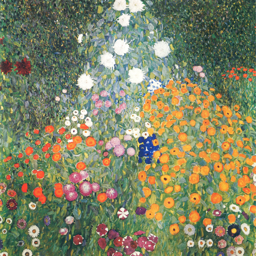

Generated Caption: the flowers look like they are floating in a garden 
Ground-truth captions: ['this serene field of flowers has many bright and vivid colors that flow so well together and makes you feel as though you are in another world', 'the bright colors on the flowers look like a happy spring day', 'i am not liking the lack of talent here i do not like the lack of detail that was put into the flowers the <unk> seem to be too off', 'this feels like a warm sunny day in a garden surrounded by the gentle perfume of flowers', 'it is a field of flowers with a nice range of color with nobody around this seems like it would be a nice area to relax and be carefree', 'it reminds me of an english garden full of flowers in bloom very cheerful', 'i feel joy looking at this painting the color in the leaves and grass bring an <unk> <unk> of <unk> the greens yellows and blues meld so perfectly the flowers themselves are gorgeous and make me feel as though i am in the field myself', 'the many co

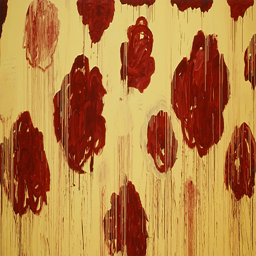

Generated Caption: the black and white flowers remind me of blood 
Ground-truth captions: ['the dark red looks like dried blood', 'the red smears look like <unk> of blood', 'this looks like red clouds in the sky which is something to see so wing', 'because the dripping red ( possibly ) flowers look like blood spatter <unk> that were running down the wall'] 



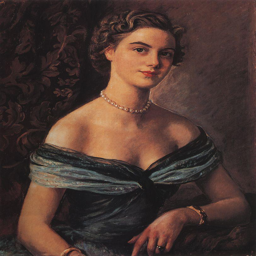

Generated Caption: the woman 's dress looks like she is glowing and ready to be a bit of a good time 
Ground-truth captions: ['the texture and facial expression make her look like a porcelain doll', 'a portrait of a woman that seems to be mildly attractive with lots of detail', 'lovely portrait of a young woman with good postures who does not look as though she posing against her will and has an actual smile', 'this is a stunning painting of a young woman in an elegant dress string of pearls <unk> accessories and well <unk> hair that reminds me of a <unk> who is classy but <unk>', 'the lady looks like she is ready to go to a party and she is thinking that she looks pretty good all dressed up', 'the woman looks like she is happy and calm'] 



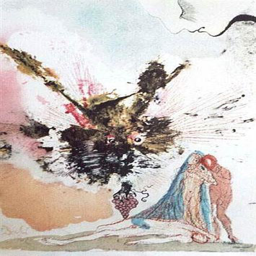

Generated Caption: the red color looks like blood wings on a dragon 
Ground-truth captions: ['there seems to be an explosion of a bird with black paint which looks disgusting', 'i am not sure what is going on here the people almost look sad but it looks like something exploded above them too', 'the blob in the center of the painting looks like it has open eyes it is really disturbing', 'it looks like there is a pair of eyes watching this couple from behind a mask of darkness', 'i am a bit unsure of what is happening but an individual appears to have been seriously hurt at the bottom it feels like a deity has been angered or <unk>'] 



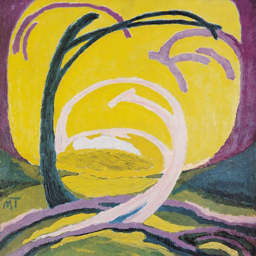

Generated Caption: the yellow circle looks like a cactus on a yellow 
Ground-truth captions: ['it looks like a large sun in the background', 'reminds me of a haunted forrest', 'the white lines are like wind flowing through a forest', 'for some reason this is a relaxing dreamy painting it looks like you are looking into a majestic wooded tunnel during sunset'] 



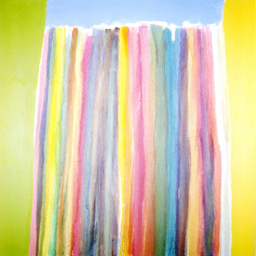

Generated Caption: the bright colors remind me of a rainbow 
Ground-truth captions: ['it looks like a bunch of different colored rubber bands on the wrist of someone', 'the stripes of color are like a rainbow waterfall', 'all the colors are so cheerful this almost makes me laugh out loud it is like a candy waterfall', 'pastel colors that look like a rainbow and remind me of easter'] 



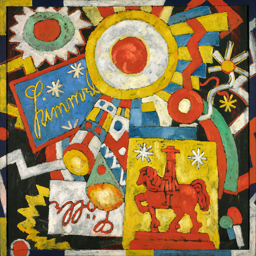

Generated Caption: the bright colors and shapes make me think of a carnival 
Ground-truth captions: ['the bright colors and patterns make it look like a party', 'reminds me of an advertisement for spain or mexico with the bright colors and geometric designs', 'the stars colors and overall clutter remind me of chinese new year', 'this looks like a pile of ads for a fair with ribbons for <unk> and elaborate candies between the signs the colors make you excited'] 



In [9]:
img_dir = '../Dataset/ArtEmis/ArtEmis_IdC/Images/rawImages/'
for random_id in [321,21,1031,208,1038,612,685]:
    row = merged.iloc[random_id]
    img_file = osp.join(img_dir, row['art_style'], row['painting'] + '.jpg')
    image = Image.open(img_file).resize((256, 256))
    display(image)
    print("Generated Caption:",row['captions_predicted'],"\nGround-truth captions:",row['references'],"\n") 